# ROBUST LINEAR REGRESSION

## Load libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1111)

## Load / generate data

In [3]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame({
    "x": x_out, 
    "y": y_out
})

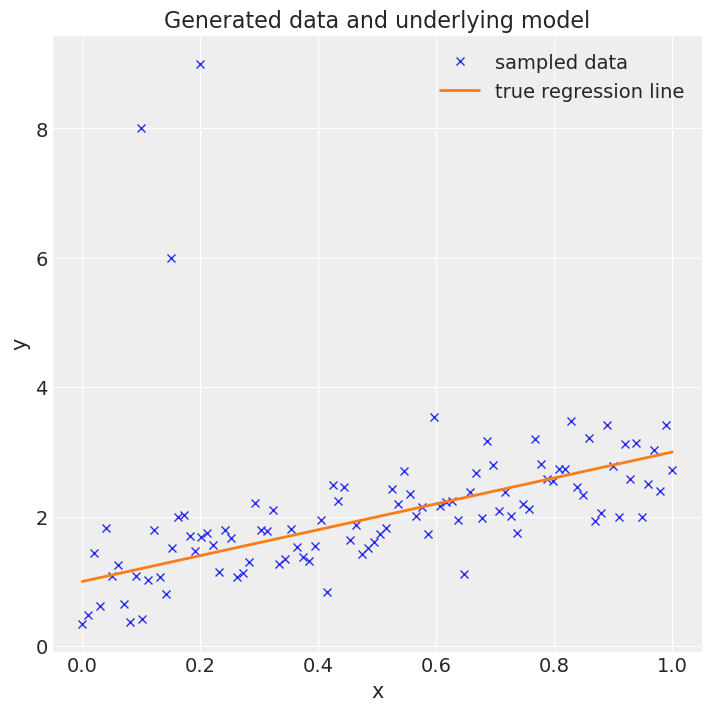

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Simple linear regression

In [6]:
gModel = bmb.Model('y ~ x', data, family = 'gaussian')

In [8]:
gModelFit = gModel.fit(draws = 2000, idata_kwargs = {'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [11]:
gModel.predict(gModelFit, kind='pps')

In [13]:
az.summary(gModelFit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.538,0.229,1.102,1.960,0.002,0.002,11417.0,6125.0,1.0
x,1.193,0.401,0.418,1.945,0.004,0.003,12327.0,5862.0,1.0
y_sigma,1.187,0.083,1.045,1.351,0.001,0.001,10362.0,5913.0,1.0
y_mean[0],1.538,0.229,1.102,1.960,0.002,0.002,11417.0,6125.0,1.0
y_mean[1],1.550,0.226,1.116,1.962,0.002,0.002,11401.0,6100.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mean[98],2.718,0.233,2.288,3.163,0.002,0.002,12025.0,6325.0,1.0
y_mean[99],2.730,0.236,2.294,3.181,0.002,0.002,12037.0,6298.0,1.0
y_mean[100],1.657,0.196,1.277,2.013,0.002,0.001,11218.0,5751.0,1.0
y_mean[101],1.716,0.181,1.368,2.048,0.002,0.001,11102.0,5708.0,1.0


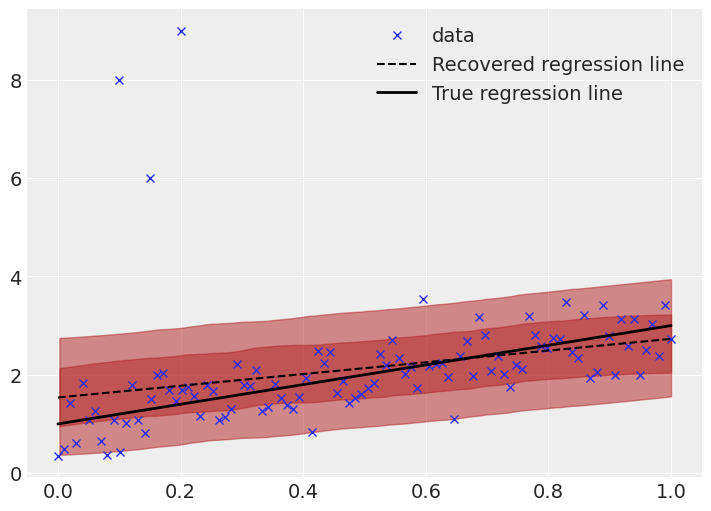

In [15]:
plt.figure(figsize=(7, 5))
# Plot Data
plt.plot(x_out, y_out, "x", label="data")
# Plot recovered linear regression
x_range = np.linspace(min(x_out), max(x_out), 2000)
y_pred = gModelFit.posterior.x.mean().item() * x_range + gModelFit.posterior.Intercept.mean().item()
plt.plot(x_range, y_pred, 
         color="black",linestyle="--",
         label="Recovered regression line"
        )
# Plot HDIs
for interval in [0.38, 0.68]:
    az.plot_hdi(x_out, gModelFit.posterior_predictive.y, 
                hdi_prob=interval, color="firebrick")
# Plot true regression line
plt.plot(x, true_regression_line, 
        label="True regression line", lw=2.0, color="black")
plt.legend(loc=0);

# Robust regression

In [17]:
tModel = bmb.Model('y ~ x', data, family = 't')

In [18]:
tModelFit = tModel.fit(draws = 2000, idata_kwargs = {'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_nu, y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


In [19]:
tModel.predict(tModelFit, kind = 'pps')

In [20]:
az.summary(tModelFit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.995,0.108,0.786,1.194,0.001,0.001,9581.0,6670.0,1.0
x,1.898,0.187,1.554,2.259,0.002,0.001,9566.0,7011.0,1.0
y_nu,2.614,0.601,1.551,3.719,0.007,0.005,7272.0,6784.0,1.0
y_sigma,0.406,0.045,0.324,0.491,0.001,0.000,6463.0,6439.0,1.0
y_mean[0],0.995,0.108,0.786,1.194,0.001,0.001,9581.0,6670.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mean[98],2.874,0.104,2.681,3.074,0.001,0.001,10357.0,6433.0,1.0
y_mean[99],2.893,0.106,2.688,3.086,0.001,0.001,10337.0,6379.0,1.0
y_mean[100],1.184,0.093,1.008,1.359,0.001,0.001,9706.0,6613.0,1.0
y_mean[101],1.279,0.085,1.119,1.441,0.001,0.001,9802.0,6364.0,1.0


## Compare models

In [24]:
def get_slope_intercept(mod):
    return (
        mod.posterior.x.mean().item(),
        mod.posterior.Intercept.mean().item()
    )
gauss_slope, gauss_int = get_slope_intercept(gModelFit)
t_slope, t_int = get_slope_intercept(tModelFit)

In [25]:
pd.DataFrame({
    "Model":["True","Normal","T"],
    "Slope":[2, gauss_slope, t_slope],
    "Intercept": [1, gauss_int, t_int]
}).set_index("Model").T.round(decimals=2)

Model,True,Normal,T
Slope,2.0,1.19,1.90
Intercept,1.0,1.54,0.99


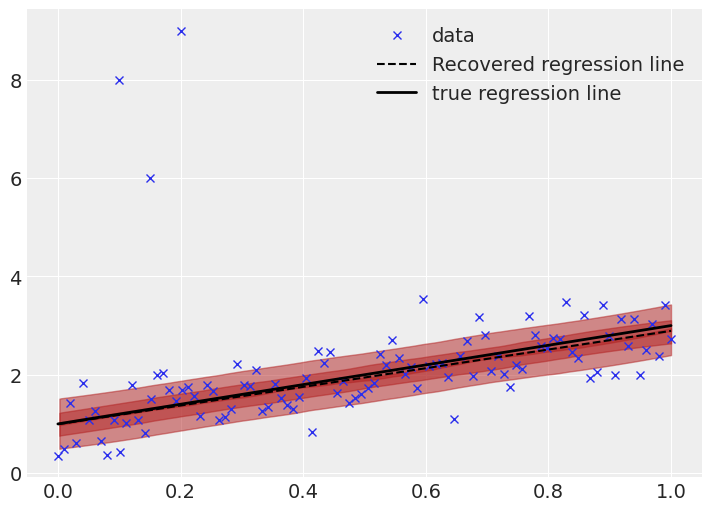

In [29]:
plt.figure(figsize=(7, 5))
# Plot Data
plt.plot(x_out, y_out, "x", label="data")
# Plot recovered robust linear regression
x_range = np.linspace(min(x_out), max(x_out), 2000)
y_pred = tModelFit.posterior.x.mean().item() * x_range + tModelFit.posterior.Intercept.mean().item()
plt.plot(x_range, y_pred, 
         color="black",linestyle="--",
         label="Recovered regression line"
        )
# Plot HDIs
for interval in [0.05, 0.38, 0.68]:
    az.plot_hdi(x_out, tModelFit.posterior_predictive.y, 
                hdi_prob=interval, color="firebrick")
# Plot true regression line
plt.plot(x, true_regression_line, 
        label="true regression line", lw=2.0, color="black")
plt.legend(loc=0);

### LOO comparison

In [31]:
models = {
    'gaussian': gModelFit,
    'Student T': tModelFit
}

In [32]:
modelCompare = az.compare(models)

modelCompare

C:\Users\bacos1\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student T,0,-101.636258,5.483787,0.000000,1.0,14.932657,0.000000,False,log
gaussian,1,-171.769528,13.827486,70.133271,0.0,29.348188,17.586559,True,log


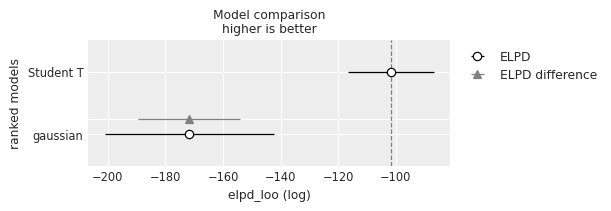

In [34]:
az.plot_compare(modelCompare, insample_dev = False);